# A/B-тест рекомендательной системы приложения

## Введение

Компания разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Необходимо рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

### Цели и задачи проекта

**Цель:** рассчитать параметры A/B-теста, который позволит проверить гипотезу, что новый алгоритм рекомендаций будет показывать более интересный контент для каждого пользователя и проанализировать его результаты.

Предположение которое будем проверять: внедрение нового рекомендательного алгоритма увеличит долю сессий с четырьмя и более просмотренными страницами на 3%. 

При проведении теста будем отслеживать отсутствие значительных изменений в количестве числа сессий в день.

**Задачи:**
1. Загрузить данные и познакомиться с их содержимым.
2. Расчет размера выборки и длительности теста.
3. Мониторинг А/В-теста.
4. Проверка результатов теста и формулирование выводов.

### Описание данных

Для анализа будут использоваться следующие данные:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей. 
- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста. 
- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).

### Содержимое проекта

1. Работа с историческими данными (EDA)
    - Загрузка исторических данных
    - Знакомство с данными
    - Анализ числа регистраций
    - Анализ числа просмотренных страниц
    - Доля пользователей, просмотревших более четырёх страниц
2. Подготовка к тесту
    - Расчёт размера выборки
    - Расчёт длительности A/B-теста
3. Мониторинг А/В-теста
    - Проверка распределения пользователей
    - Проверка пересечений пользователей
    - Равномерность разделения пользователей по устройствам
    - Равномерность распределения пользователей по регионам
    - Вывод после проверки A/B-теста
4. Проверка результатов A/B-теста
    - Получение результатов теста и подсчёт основной метрики
    - Проверка корректности результатов теста
    - Сравнение доли успешных сессий
    - Насколько статистически значимо изменение ключевой метрики
    - Вывод по результатам A/B-эксперимента

---

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных

Импортируем необходимые библиотеки для анализа данных. Затем выгрузим данные из датасета и выведем основную информацию о данных и первые строки датафрейма.

- Импортируем библиотеки

In [1]:
# Библиотеки для обработки и анализа данных
import pandas as pd
import numpy as np
from math import ceil

# Библиотеки для визуализации данных
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib_venn import venn2

# Библиотека для статистического анализа
from statsmodels.stats.power import zt_ind_solve_power 
from statsmodels.stats.proportion import proportion_effectsize
from scipy.stats import ttest_ind

In [2]:
# Выгружаем данные в переменную sessions_history
path = "..."

sessions_history = pd.read_csv(path + 'sessions_project_history.csv',
                               parse_dates=['session_date', 'session_start_ts', 'install_date'])

- Выведим общую информацию о датасетах и первые пять строк.

In [3]:
# Общая информация о датафрейме
sessions_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   user_id            435924 non-null  object        
 1   session_id         435924 non-null  object        
 2   session_date       435924 non-null  datetime64[ns]
 3   session_start_ts   435924 non-null  datetime64[ns]
 4   install_date       435924 non-null  datetime64[ns]
 5   session_number     435924 non-null  int64         
 6   registration_flag  435924 non-null  int64         
 7   page_counter       435924 non-null  int64         
 8   region             435924 non-null  object        
 9   device             435924 non-null  object        
dtypes: datetime64[ns](3), int64(3), object(4)
memory usage: 33.3+ MB


In [4]:
# Выводим первые строки датафрейма на экран   
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


Тип данных определился верно и не требует изменений. Названия столбцов во всех датафреймах записаны в едином стиле "snake case" и соответсвуют содержимому.

#### 1.2. Знакомство с данными

- Проверим данные на явные и неявные дубликаты.

In [5]:
# Проверяем на полные дубликаты
print(f'Количество полных дубликатов: {sessions_history.duplicated().sum()} строк.')

Количество полных дубликатов: 0 строк.


In [6]:
# Проверяем на неявные дубликаты (включаем поля)
with_clm = [['session_id'], ['user_id', 'session_id'], ['user_id', 'session_start_ts']]
for i, clm in enumerate(with_clm):
    print(f'{i+1}. Количество неявных дубликатов по {clm}:\n {sessions_history.duplicated(clm).sum()} строк.\n')

1. Количество неявных дубликатов по ['session_id']:
 0 строк.

2. Количество неявных дубликатов по ['user_id', 'session_id']:
 0 строк.

3. Количество неявных дубликатов по ['user_id', 'session_start_ts']:
 0 строк.



- Для каждого уникального пользователя `user_id` рассчитаем количество уникальных сессий `session_id`.

- Выведим на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберим одного из них и проанализируем таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.

In [7]:
# Рассчет количества уникальных сессий для каждого пользователя
cnt_session = sessions_history.groupby('user_id', as_index=False).agg(count_session=('session_id', 'nunique'))

# Один из пользователей с максимальным количеством сессий
user_with_max_session = cnt_session.sort_values('count_session').tail(1).iloc[0, 0]

# Вывод данных по пользователю с максимальным количеством сессий
sessions_history[sessions_history['user_id']==user_with_max_session]

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
124515,6A73CB5566BB494D,110E3F28C1F5415F,2025-08-28,2025-08-28 18:58:19,2025-08-28,1,0,3,MENA,Mac
196252,6A73CB5566BB494D,D68C8D98A0F1C439,2025-08-29,2025-08-29 20:53:27,2025-08-28,2,1,3,MENA,Mac
242428,6A73CB5566BB494D,6587D217472BF807,2025-08-30,2025-08-30 13:08:22,2025-08-28,3,1,1,MENA,Mac
304287,6A73CB5566BB494D,A9BC25593D056F8E,2025-09-01,2025-09-01 18:52:49,2025-08-28,4,1,2,MENA,Mac
346611,6A73CB5566BB494D,CB6F9C4191FAF6F6,2025-09-03,2025-09-03 22:49:08,2025-08-28,5,1,3,MENA,Mac
363510,6A73CB5566BB494D,9C609432F6E6535A,2025-09-04,2025-09-04 13:59:46,2025-08-28,6,1,4,MENA,Mac
391902,6A73CB5566BB494D,5D892E33B97A257A,2025-09-06,2025-09-06 18:46:55,2025-08-28,7,1,2,MENA,Mac
404322,6A73CB5566BB494D,22A9BD3861F49087,2025-09-07,2025-09-07 18:33:49,2025-08-28,8,1,3,MENA,Mac
415489,6A73CB5566BB494D,F70E351154B092DC,2025-09-08,2025-09-08 20:30:22,2025-08-28,9,1,4,MENA,Mac
425805,6A73CB5566BB494D,84A3DC0CFF449F53,2025-09-09,2025-09-09 16:36:04,2025-08-28,10,1,1,MENA,Mac


Максимальное количество сессий на одного пользователя - 10. Пользователь каждый раз заходил с одного типа устройства - Мас. Каждому дню соответствует одна сессия, у пользователя нет дней с несколькими сессиями. 

#### 1.3. Анализ числа регистраций

Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, проанализируем, как менялось число регистраций в приложении за время его существования.

Агрегируем исторические данные и рассчитаем число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения.

In [8]:
# Число уникальных пользователей для каждого дня наблюдения
cnt_users = sessions_history.groupby('session_date')['user_id'].nunique()

# Число зарегистрированных пользователей для каждого дня наблюдения
cnt_reg_users = sessions_history[sessions_history['registration_flag']==1].groupby('session_date')['user_id'].nunique()

Построим линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням.

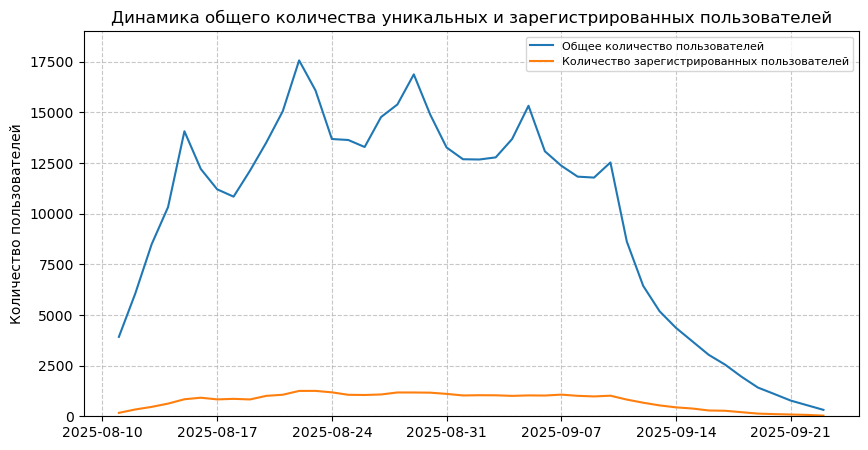

In [9]:
# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 5))

# Строим линейный график
data=cnt_users.reset_index()
sns.lineplot(data=data, 
             x='session_date', 
             y='user_id', 
             label='Общее количество пользователей'
            )

# Строим линейный график
data2=cnt_reg_users.reset_index()
sns.lineplot(data=data2, 
             x='session_date', 
             y='user_id', 
             label='Количество зарегистрированных пользователей'
            )

# Настраиваем оформление графика
plt.title('Динамика общего количества уникальных и зарегистрированных пользователей')
plt.xlabel('')
plt.ylabel('Количество пользователей')
plt.ylim(0, 19000)
plt.legend(fontsize=8)

# Частотат меток в днях
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))

# Добавляем сетку графика
plt.grid(linestyle='--', alpha=0.7)

# Выводим график
plt.show()

Число уникальных зарегистрированных пользователей за исследуемый период сначало растет, потом снижается и к концу анализируемого периода достигает минимума. Динамика количества зарегистрированных пользователей ведет себя аналогичным образом.

Построим линейный график доли зарегистрированных пользователей от всех пользователей по дням.

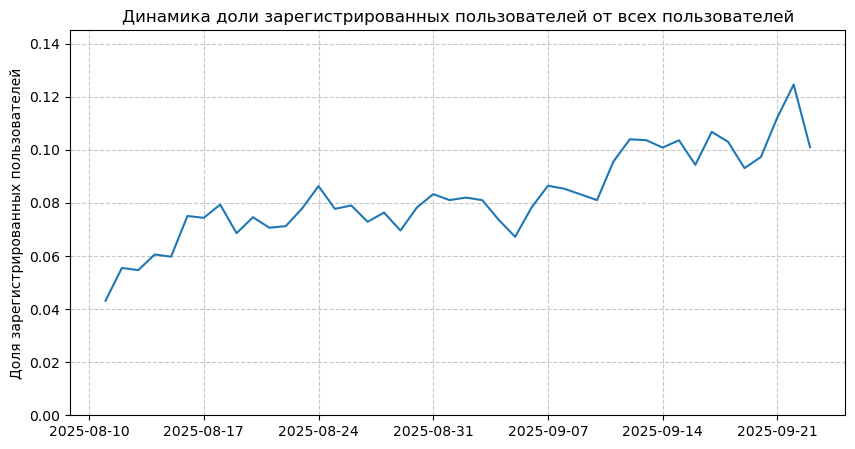

In [10]:
# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 5))

# Данные для графика
share_reg_users = cnt_reg_users / cnt_users
data=share_reg_users.reset_index()

# Строим линейный график
sns.lineplot(data=data, 
             x='session_date', 
             y='user_id'
            )

# Настраиваем оформление графика
plt.title('Динамика доли зарегистрированных пользователей от всех пользователей')
plt.xlabel('')
plt.ylabel('Доля зарегистрированных пользователей')
plt.ylim(0, 0.145)

# Частотат меток в днях
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))

# Добавляем сетку графика
plt.grid(linestyle='--', alpha=0.7)

# Выводим график
plt.show()

Доля зарегистрированных пользователей растет за анализируемый период.

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы на то, что он зарегистрируется и оплатит подписку.

Рассчитаем количество сессий для каждого значения количества просмотренных страниц и построим столбчатую диаграмму.

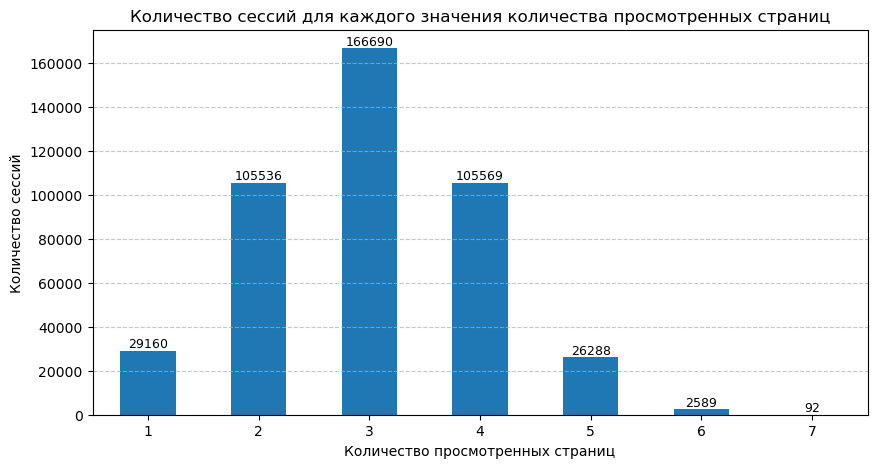

In [11]:
# Количество сессий для каждого значения количества просмотренных страниц
cnt_session = sessions_history.groupby('page_counter')['session_id'].nunique()

# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 5))

# Строим столбчатую диаграмму
cnt_session.plot(kind='bar', 
                 rot=0
                )

# Настраиваем оформление графика
plt.title('Количество сессий для каждого значения количества просмотренных страниц')
plt.xlabel('Количество просмотренных страниц')
plt.ylabel('Количество сессий')

# Добавляем сетку графика
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Подписи значений над столбцами
for i, v in enumerate(cnt_session.values):
    plt.text(cnt_session.index[i]-1, v, str(v), ha='center', va='bottom', fontsize=9)

# Выводим график
plt.show()

Обычно пользователи просматирают от 2 до 4 страниц, чаще всего - 3 страницы.

#### 1.5. Доля пользователей, просмотревших более четырёх страниц

В датафрейме `sessions_history` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше и построим график со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения.

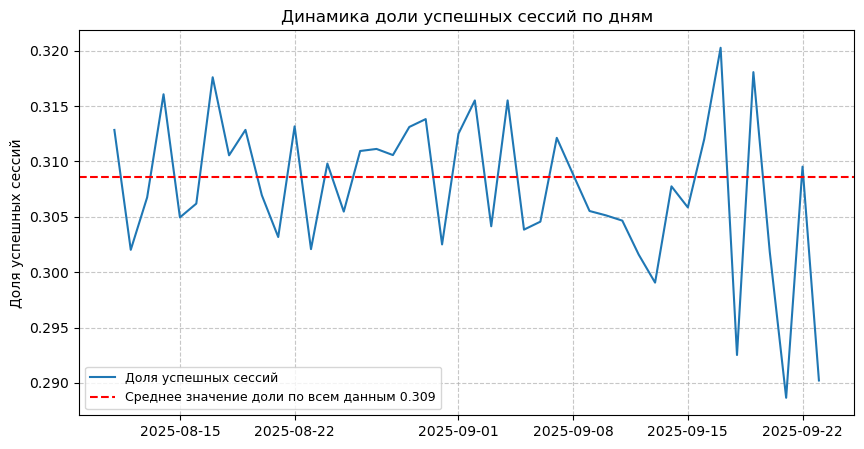

In [12]:
# В столбец good_session записывем 1, если за одну сессию было просмотрено 4 и более страниц
sessions_history['good_session'] = np.where(sessions_history['page_counter']>=4, 1, 0)

# Рассчитываем доли успешных сессий ко всем сессиям по дням
share_good_session = sessions_history.groupby('session_date')['good_session'].mean()

# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 5))

# Строим линейный график
data=share_good_session.reset_index()
sns.lineplot(data=data, 
             x='session_date', 
             y='good_session',
             label='Доля успешных сессий'
            )

# Рассчитываем среднее значение доли успешных сессий за весь период наблюдения
med_ind = sessions_history['good_session'].mean()

# Наносим на график линию со средним значением по всем данным
plt.axhline(med_ind, 
            color='red',
            linestyle='--',
            label=f'Среднее значение доли по всем данным {round(med_ind, 3)}'
           )

# Настраиваем оформление графика
plt.title('Динамика доли успешных сессий по дням')
plt.xlabel('')
plt.ylabel('Доля успешных сессий')
plt.legend(fontsize=9)

# Добавляем сетку графика
plt.grid(linestyle='--', alpha=0.7)

# Выводим график
plt.show()

Общая доля успешных сессий за весь анализируемый период составила 0.309. В конце исследуемого периода доля успешных сессий по дням снизилась - это может быть связано со спадом активности пользователей.

---

### 2. Подготовка к тесту

#### 2.1. Расчёт размера выборки

Рассчитаем размер выборки. Для этого установите в коде ниже следующие параметры:

- Уровень значимости — 5%.

- Вероятность ошибки второго рода — 20%.

- Мощность теста — 80%.

- Минимальный детектируемый эффект (MDE) — 3%.

In [13]:
# Параметры
alpha = 0.05          # Уровень значимости (5%)
power = 0.8           # Мощность теста (80%)
p1 = 0.309            # Доля в контрольной группе (базовая доля)
mde = 0.03            # MDE = 3% 

# Доля в экспериментальной группе
p2 = p1 + mde         # Если MDE абсолютный

# Расчет эффекта (Cohen's h)
effect_size = proportion_effectsize(p1, p2)

# Расчет размера выборки
sample_size_per_group = zt_ind_solve_power(effect_size=effect_size,
                                           alpha=alpha,
                                           power=power,
                                           ratio=1.0,  # Соотношение групп (1:1)
                                          )

# Округление вверх
sample_size_per_group = ceil(sample_size_per_group)

print(f'Размер выборки для каждой группы: {sample_size_per_group}')
print(f'Общий размер выборки: {2 * sample_size_per_group}')

Размер выборки для каждой группы: 3819
Общий размер выборки: 7638


При проведении A/B-теста с таким размером выборки для каждой группы, мы с вероятостью 80% и уровнем значимости 5% обнаружим статистически значимое изменение метрики на 3% (размер эффекта в абсолютном выражении).

#### 2.1. Расчёт длительности A/B-теста

Рассчитаем длительность теста. Для этого разделим размер выборки на среднее количество уникальных пользователей приложения в день. Так как в последнии дни трафик падает, среднее количество уникальных пользователей приложения в день расчитаем за последнюю неделю.

In [14]:
# Среднее количество пользователей приложения в день по историческим данным за последние 7 дней
period = 7
avg_daily_users = round(cnt_users.sort_index().tail(period).mean())

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil((2 * sample_size_per_group) / avg_daily_users)

print(f'Длительность A/B-теста при среднем уровене трафика в {avg_daily_users} пользователей в день,')
print(f'расчитаном за последние {period} дней, составит: {test_duration} дней.')

Длительность A/B-теста при среднем уровене трафика в 1237 пользователей в день,
расчитаном за последние 7 дней, составит: 7 дней.


---

### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей


На этом этапе убедимся, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие нас метрики корректно считаются.

Загрузим данные в датафрейм `sessions_test_part` из CSV-файла с первыми полученными данными о сессиях пользователей `sessions_project_test_part.csv`.

In [15]:
# Выгружаем данные в переменную sessions_test_part
sessions_test_part = pd.read_csv(path + 'sessions_project_test_part.csv')

# Количество дней наблюдений
print(f'Количество дней наблюдений: {sessions_test_part['session_date'].nunique()}')

Количество дней наблюдений: 1


Рассчитаем количество уникальных пользователей в группах за этот день.

In [16]:
# Рассчитываем количество уникальных пользователей в группах
cnt_users_test_part = sessions_test_part.groupby('test_group').agg(count_users=('user_id', 'nunique'))

print('Количество уникальных пользователей в группах \n', cnt_users_test_part)

# Расчет процентной разницы в количестве пользователей в группах A и B
a = cnt_users_test_part.loc['A', 'count_users']
b = cnt_users_test_part.loc['B', 'count_users']

diff_per = abs(a - b) / a * 100

print(f'\nОтносительная разница в количестве пользователей в группах A и B составляет: {diff_per:.2f}%')

Количество уникальных пользователей в группах 
             count_users
test_group             
A                  1477
B                  1466

Относительная разница в количестве пользователей в группах A и B составляет: 0.74%


Построим круговую диаграммую по количеству уникальных пользователей в группах.

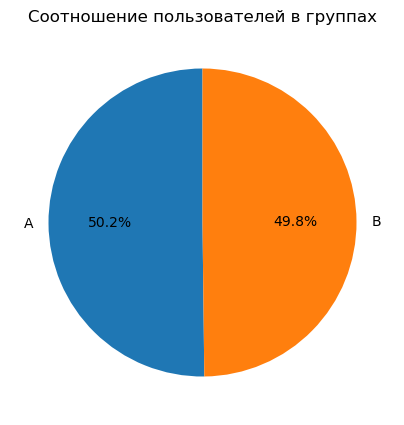

In [17]:
# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(5, 5))

# Строим круговую диаграмму
cnt_users_test_part['count_users'].plot(kind='pie',
                                        startangle=90,
                                        label='',
                                        title='Соотношение пользователей в группах',
                                        autopct='%.1f%%'
                                       )

# Выводим график
plt.show()

#### 3.2. Проверка пересечений пользователей

Исследуем группы на независимость, проверим что нет пользователей, участвующих одновременно в двух группах.

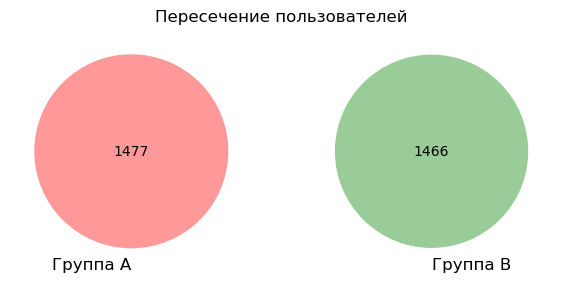


Количество пользователей, которые встречаются одновременно в группах A и B: 0


In [18]:
# Отбор данных по группе А
gr_a = sessions_test_part[sessions_test_part['test_group'] == 'A']

# Отбор данных по группе В
gr_b = sessions_test_part[sessions_test_part['test_group'] == 'B']

# Определение пользователей одновременно входящих в группу A и B
intersection = list(set(gr_a['user_id']) & set(gr_b['user_id']))

# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(7, 7))

# Строим диаграмму Венна 
venn2([set(gr_a['user_id']), set(gr_b['user_id'])], 
      set_labels=('Группа A', 'Группа В')
     )

# Настраиваем оформление графика
plt.title("Пересечение пользователей") 

# Выводим график
plt.show()

print(f'\nКоличество пользователей, которые встречаются одновременно в группах A и B: {len(intersection)}') 

#### 3.3. Равномерность разделения пользователей по устройствам

Убедимся в том, что пользователи равномерно распределены по типам устройств. Для этого построим столбчатые диаграммы с долями.

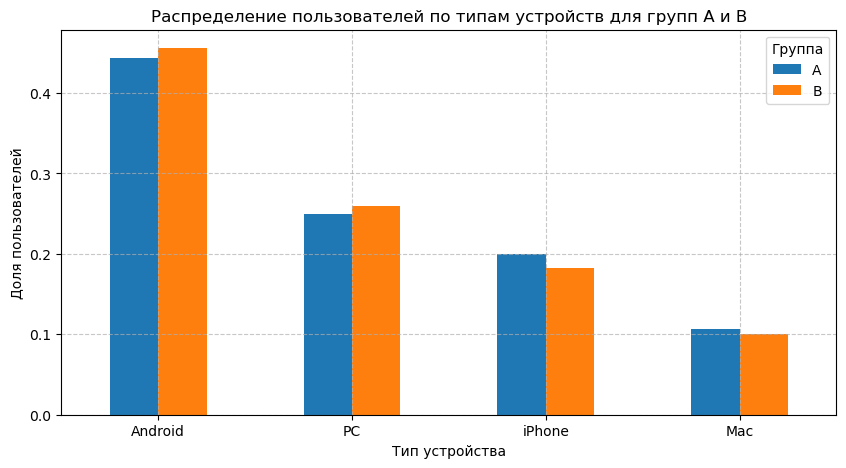


Распределение пользователей по типам устройств для групп A и B


test_group,A,B
device,,
Android,0.444,0.456
PC,0.250,0.260
iPhone,0.200,0.183
Mac,0.106,0.101


In [19]:
# Отбор данных для диаграммы
device_gr = sessions_test_part.groupby(['test_group', 'device'])['user_id'].nunique().unstack(0)
share_device_gr = round(device_gr/device_gr.sum(), 3).sort_values(by='A', ascending=False)

# Построим график столбчатой диаграммы
share_device_gr.plot(kind='bar',
                     rot=0,
                     figsize=(10, 5)
                    )

# Настраиваем оформление графика
plt.title('Распределение пользователей по типам устройств для групп A и B')
plt.xlabel('Тип устройства')
plt.ylabel('Доля пользователей')
plt.legend(title='Группа')

# Добавляем сетку графика
plt.grid(linestyle='--', alpha=0.7)

# Выводим график
plt.show()

print('\nРаспределение пользователей по типам устройств для групп A и B') 
share_device_gr

Пользователи в группах А и В по типам устройств распределены схоже.

#### 3.4. Равномерность распределения пользователей по регионам

Теперь убедитесь, что пользователи равномерно распределены по регионам. Для этого построим столбчатые диаграммы с долями.

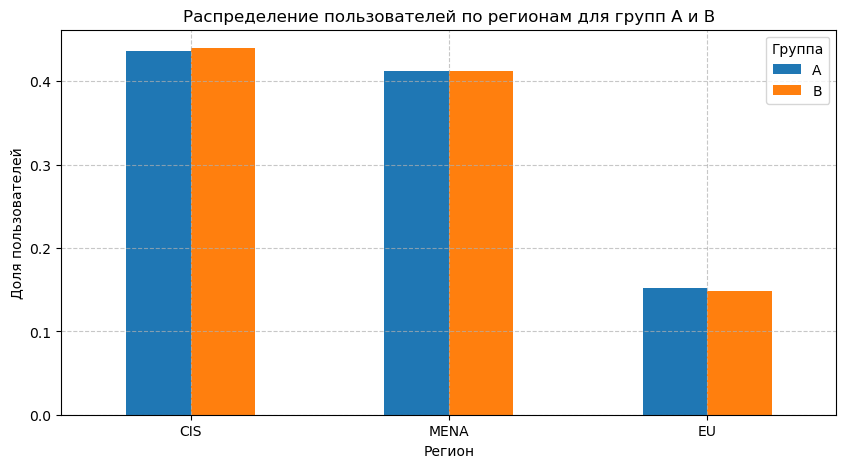


Распределение пользователей по регионам для групп A и B


test_group,A,B
region,,
CIS,0.436,0.440
MENA,0.412,0.412
EU,0.152,0.148


In [20]:
# Отбор данных для диаграммы
region_gr = sessions_test_part.groupby(['test_group', 'region'])['user_id'].nunique().unstack(0)
share_region_gr = round(region_gr/region_gr.sum(), 3).sort_values(by='A', ascending=False)

# Построим график столбчатой диаграммы
share_region_gr.plot(kind='bar',
                     rot=0,
                     figsize=(10, 5)
                    )

# Настраиваем оформление графика
plt.title('Распределение пользователей по регионам для групп A и B')
plt.xlabel('Регион')
plt.ylabel('Доля пользователей')
plt.legend(title='Группа')

# Добавляем сетку графика
plt.grid(linestyle='--', alpha=0.7)

# Выводим график
plt.show()

print('\nРаспределение пользователей по регионам для групп A и B') 
share_region_gr

Пользователи в группах А и В по регионам распределены схоже.

#### 3.5. Вывод после проверки A/B-теста

По результатам мониторинга первого дня теста были получены следующие результаты:
- пользователи в группах А и В распределены почти одинакого (в А - 1477, в В - 1466), относительная разница в количестве пользователей составила 0.74%;
- пересечение пользователей из тестовой и контрольной групп не обноружено - группы независимы;
- пользователи в тестовой и контрольной группах по категориальным переменным (устройствам и регионам) распределены схоже, критических расхождений нет.

Тест проходит корректно.

---

### 4. Проверка результатов A/B-теста


#### 4.1. Получение результатов теста и подсчёт основной метрики

- Загрузим в датафрейм `sessions_test` данные из CSV-файла с информацией о проведенном эксперименте `sessions_project_test.csv`.

- В датафрейме `sessions_test` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше и выведим общую информацию о полученном датафрейме.

In [21]:
# Выгружаем данные в переменную sessions_test
sessions_test = pd.read_csv(path + 'sessions_project_test.csv',
                            parse_dates=['session_date', 'session_start_ts', 'install_date'])

In [22]:
# В столбец good_session записывем 1, если за одну сессию было просмотрено 4 и более страниц
sessions_test['good_session'] = np.where(sessions_test['page_counter']>=4, 1, 0)

In [23]:
# Общая информация о датафрейме
sessions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100005 entries, 0 to 100004
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   user_id            100005 non-null  object        
 1   session_id         100005 non-null  object        
 2   session_date       100005 non-null  datetime64[ns]
 3   session_start_ts   100005 non-null  datetime64[ns]
 4   install_date       100005 non-null  datetime64[ns]
 5   session_number     100005 non-null  int64         
 6   registration_flag  100005 non-null  int64         
 7   page_counter       100005 non-null  int64         
 8   region             100005 non-null  object        
 9   device             100005 non-null  object        
 10  test_group         100005 non-null  object        
 11  good_session       100005 non-null  int32         
dtypes: datetime64[ns](3), int32(1), int64(3), object(5)
memory usage: 8.8+ MB


Все данные заполнены. Проверим данные на явные и неявные дубликаты.

In [24]:
# Проверяем на полные дубликаты
print(f'Количество полных дубликатов: {sessions_test.duplicated().sum()} строк.')

Количество полных дубликатов: 0 строк.


In [25]:
# Проверяем на неявные дубликаты (включаем поля)
with_clm = [['session_id'], ['user_id', 'session_id'], ['user_id', 'session_start_ts']]
for i, clm in enumerate(with_clm):
    print(f'{i+1}. Количество неявных дубликатов по {clm}:\n {sessions_test.duplicated(clm).sum()} строк.\n')

1. Количество неявных дубликатов по ['session_id']:
 0 строк.

2. Количество неявных дубликатов по ['user_id', 'session_id']:
 0 строк.

3. Количество неявных дубликатов по ['user_id', 'session_start_ts']:
 0 строк.



Рассчитаем продолжительность теста и количество пользователей задействованных в тесте.

In [26]:
print(f"Продолжительность теста: {sessions_test['session_date'].nunique()} дней.")

Продолжительность теста: 20 дней.


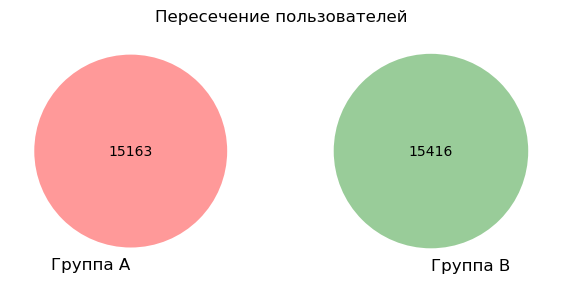


Количество пользователей, которые встречаются одновременно в группах A и B: 0
Количество уникальных пользователей, принявших участие тесте - 30579,
из них в группе А - 15163, в группе В - 15416.


In [27]:
# Количество уникальных пользователей
cnt_users_test = sessions_test.groupby('test_group')['user_id'].nunique()

# Отбор данных по группе А
gr_a = sessions_test[sessions_test['test_group'] == 'A']

# Отбор данных по группе В
gr_b = sessions_test[sessions_test['test_group'] == 'B']

# Определение пользователей одновременно входящих в группу A и B
intersection = list(set(gr_a['user_id']) & set(gr_b['user_id']))

# Строим диаграмму Венна 
plt.figure(figsize=(7, 7))

venn2([set(gr_a['user_id']), set(gr_b['user_id'])], 
      set_labels=('Группа A', 'Группа В')
     )

plt.title("Пересечение пользователей") 
plt.show()

print(f'\nКоличество пользователей, которые встречаются одновременно в группах A и B: {len(intersection)}') 
print(f"Количество уникальных пользователей, принявших участие тесте - {cnt_users_test.sum()},")
print(f"из них в группе А - {cnt_users_test['A'].sum()}, в группе В - {cnt_users_test['B'].sum()}.")

#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, проверим, что тест проведён корректно и мы будем сравнивать две сопоставимые группы. 
Рассчитаем количество уникальных сессий для каждого дня в обеих тестовых групп и проверим, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы. Для проверки будем использовать двусторонний t-тест Уэлча, который позволит сделать вывод о равенстве средних двух выборок.

Тогда статистические гипотезы будут выглядеть так:
- Нулевая гипотеза: выборочные средние в группах А и В равны.

$$H_{0}: \mu_{A} = \mu_{B}$$
- Альтернативная гипотеза: выборочные средние в группах А и В не равны.

$$H_{1}: \mu_{A} \neq \mu_{B}$$

In [28]:
# Отбор данных теста по группе А
session_test_gr_a = sessions_test[sessions_test['test_group']=='A'].groupby('session_date')['session_id'].nunique()

# Отбор данных теста по группе В
session_test_gr_b = sessions_test[sessions_test['test_group']=='B'].groupby('session_date')['session_id'].nunique()

print(f'Количество уникальных сессий в группе А={session_test_gr_a.sum()}')
print(f'Количество уникальных сессий в группе B={session_test_gr_b.sum()}')

# Применим двусторонний t-тест Уэлча
stat_ttest, p_value = ttest_ind(session_test_gr_a,
                                session_test_gr_b,
                                equal_var=False, 
                                alternative='two-sided'
                               )

if p_value < alpha:
    print(f'Полученное значение p-value={p_value:.4f} меньше критического уровня alpha={alpha}.')
    print('Принимаем альтернативную гипотезу. Выборочные средние в группах А и В не равны.')
    print('Количество уникальных дневных сессий в двух выборках различается.')
else:
    print(f'Полученное значение p-value={p_value:.4f} больше критического уровня alpha={alpha}.')
    print('Опровергнуть нулевую гипотезу нельзя. Выборочные средние в группах А и В равны.')
    print('Количество уникальных дневных сессий в двух выборках не различается.')

Количество уникальных сессий в группе А=49551
Количество уникальных сессий в группе B=50454
Полученное значение p-value=0.9382 больше критического уровня alpha=0.05.
Опровергнуть нулевую гипотезу нельзя. Выборочные средние в группах А и В равны.
Количество уникальных дневных сессий в двух выборках не различается.


#### 4.3. Сравнение доли успешных сессий

Рассчитаем ключевой показатель - доля успешных сессий для выборок А и В и разницу в этом показателе.

In [29]:
# Доля успешных сессий в группе А
share_good_session_a = sessions_test[sessions_test['test_group']=='A']['good_session'].mean()

# Доля успешных сессий в группе В
share_good_session_b = sessions_test[sessions_test['test_group']=='B']['good_session'].mean()

# Разница между успешными долями группы А и В
diff_in_share = share_good_session_b - share_good_session_a

print(f'Доля успешных сессий в группе А={round(share_good_session_a, 4)}, доля успешных сессий в группе В={round(share_good_session_b, 4)}.')
print(f'Разница между долями успешных сессий в группе А и В составляет {round(diff_in_share, 4)}.')

Доля успешных сессий в группе А=0.3077, доля успешных сессий в группе В=0.3183.
Разница между долями успешных сессий в группе А и В составляет 0.0106.


#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге мы убедились, что количество успешных сессий в тестовой выборке (группа В) на 1.1% выше, чем в контрольной (группа А), но делать выводы только на основе этого значения будет некорректно. Для проверки является ли изменение в метрике доли успешных сессий статистически значимым будем использовать Z-тест пропорций. Статистические гипотезы будут выглядеть так:
- Доля успешных сессий в группе А не меньше, чем в группе В.

$$H_{0}: p_{A} \geq p_{B}$$
- Доля успешных сессий в группе А меньше, чем в группе В.

$$H_{1}: p_{A} < p_{B}$$
  
Перед выполнением теста проверим, выполняется ли предпосылка Z-теста пропорций о достаточном размере выборок. Для этого посчитаем количество наблюдений в каждой группе, а также количество успешных сессий.

In [30]:
# Импорт функции proportions_ztest
from statsmodels.stats.proportion import proportions_ztest

# Рассчитываем размер выборки для каждой из групп
n_a = len(sessions_test[sessions_test['test_group']=='A'])
n_b = len(sessions_test[sessions_test['test_group']=='B'])

# Рассчитываем количество успешных сессий для каждой из групп
m_a = len(sessions_test[(sessions_test['test_group']=='A') & (sessions_test['good_session']==1)])
m_b = len(sessions_test[(sessions_test['test_group']=='B') & (sessions_test['good_session']==1)])

# Проверяем условие о достаточности выборки
if (m_a / n_a * n_a > 10) and ((1 - m_a / n_a) * n_a > 10) and (m_b/n_b * n_b > 10) and ((1 - m_b / n_b) * n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных не выполняется!')

# Односторонний Z-тест для пропорций
stat_ztest, p_value_ztest = proportions_ztest([m_a, m_b],
                                              [n_a, n_b],
                                              alternative='smaller' # H1: m_a/n_a < m_b/n_b
                                             )

if p_value_ztest > alpha:
    print(f'Полученное значение p_value={p_value_ztest:.4f} больше критического уровня alpha={alpha}.')
    print('Нулевая гипотеза находит подтверждение! Доля успешных сессий в группе А не меньше, чем в группе В.')
else:
    print(f'Полученное значение p_value={p_value_ztest:.4f} меньше критического уровня alpha={alpha}.')
    print('Нулевая гипотеза не находит подтверждения! Доля успешных сессий в группе А меньше, чем в группе В.')

Предпосылка о достаточном количестве данных выполняется!
Полученное значение p_value=0.0002 меньше критического уровня alpha=0.05.
Нулевая гипотеза не находит подтверждения! Доля успешных сессий в группе А меньше, чем в группе В.


#### 4.5. Вывод по результатам A/B-эксперимента

**После проведения А/В-теста и анализа результата можем сделать следующие выводы:**
- Тест длился 20 дней, в нем было приняло участие 30579 пользователя, 15163 в группе А и 15416 в группе В, проанализировано 100005 сессий. Длительность теста и размер выбороки превысили минимально необходимые расчетные величины.  
- Внедрение нового алгоритма рекомендаций увеличило ключевую метрику - долю успешных сессий на 1.06%. Доля успешных сессий в тестовой группе В - 0.3183, в контрольной группе А - 0.3077.
- При проведении Z-теста пропорций получили p-value = 0.0002 меньше критического уровня alpha = 0.05, что подтверждает статистическую значимость полученого результата: доля успешных сессий в группе В больше, чем доля успешных сессий в группе А.
- Несмотря на то, что Z-тест показал статистическую значимость увеличения доли успешных сессий, эффект увеличения на 1.06% оказался ниже MDE (3%) - эффект экономически незначим, разница слишком мала, чтобы быть полезной - внедрять нововведение в приложение не стоит.